#### Lesson Objectives

* learn how to build and visualize a network from spatial data
* learn how to calculate geographic distances
* learn how to extract connectivity properties of a network from the algebraic properties of its graph

In [1]:
# import common modules
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os

#### US state capital dataset

We will use a dataset of the US state capitals which contains their geographic coordinates.

To read the dataset into Python we use the `pandas` built-in function to read csv files.

In [2]:
# reading the data
data = pd.read_csv(os.path.join('data','state_capitals.csv'))

In [3]:
# data structure
data.head()

,name,description,latitude,longitude
0,Alabama,Montgomery,32.377716,-86.300568
1,Alaska,Juneau,58.301598,-134.420212
2,Arizona,Phoenix,33.448143,-112.096962
3,Arkansas,Little Rock,34.746613,-92.288986
4,California,Sacramento,38.576668,-121.493629


Let's directly plot the locations of the cities.

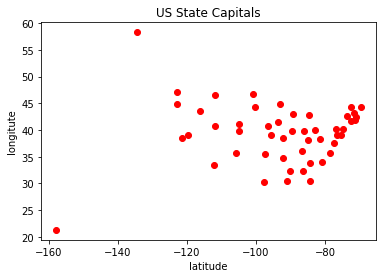

In [4]:
# plotting the locations of the cities
plt.plot(data['longitude'],data['latitude'],'ro')
plt.ylabel('longitute')
plt.xlabel('latitude')
plt.title('US State Capitals')

#### Calculating distances

Next we want to calculate the distance between every pair of cities. How can we do that?

Clearly, we cannot use the Euclidean distance between the coordinates since the earth is not flat. To calculate a point between any two points on a sphere we can use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula). (We know that the earth is not a complete spheroid, so this formula is just an approximation.)


So let's create our own distance function:

In [5]:
import math

def spherical_distance(origin, destination):
    # distance between two points on earth
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # in km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return(d)# in km

In [6]:
spherical_distance(data[['latitude','longitude']].iloc[0], data[['latitude','longitude']].loc[2])

2404.818420383192

It is easy to calculate the distance between two cities but it will take a while to calculate the distance for each pair. We can speed up the process by using a useful function in the `scipy` package.

In [7]:
from scipy.spatial import distance

In [8]:
# calculate all pairwise distances using a custom function
Dist = distance.pdist(data[['latitude','longitude']],spherical_distance)
Dist.shape

(1225L,)

To save space the distance function computes only the upper triangle of a distance matrix. But we can get the full distance matrix:

In [9]:
Dist = distance.squareform(Dist)

#### Building the city network

We will say that two cities are connected if the distance between them is less than 300km.

The whole city network then can be represented by an *adjacency matrix* A whose element is 1 for nodes which are connected and zero otherwise.

In [10]:
# Adjacency matrix
A = Dist<100
A.shape

(50L, 50L)

To visualize the network in Python we will use the `networkx` package.

In [11]:
import networkx as nx

G = nx.from_numpy_matrix(A)

In [12]:
type(G)

networkx.classes.graph.Graph

In Python then the network is stored as lists of nodes and edges (which is more efficient than storing the full adjacency matrix):

In [13]:
G.nodes()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [14]:
G.edges()

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 19),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (20, 38),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49)]

Let's look at the network.

C:\Users\saisi\Anaconda2\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\saisi\Anaconda2\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\saisi\Anaconda2\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\saisi\Anaconda2\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

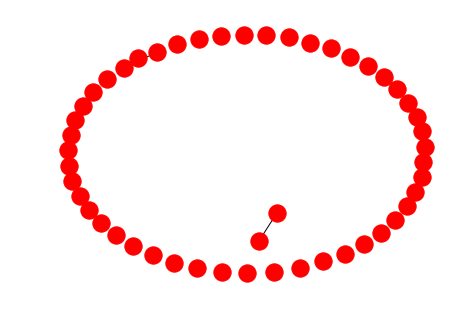

In [15]:
nx.draw(G)

Well, that does not look like the original map. 

Let's fix the layout by adding the geospatial coordinates:

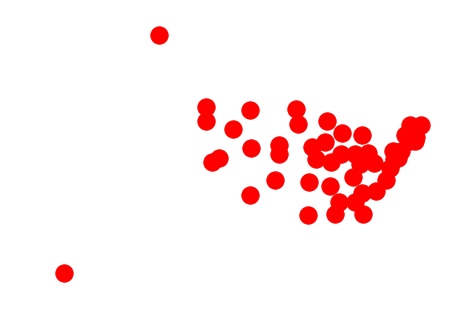

In [16]:
nx.draw(G,np.array(data[['longitude','latitude']]))

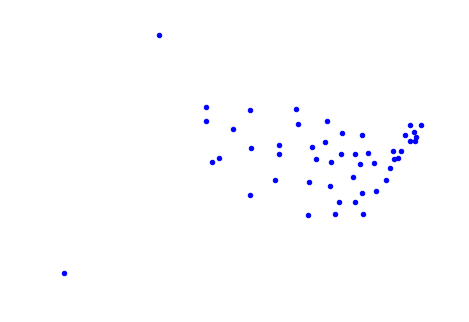

In [17]:
nx.draw(G,np.array(data[['longitude','latitude']]),node_color = 'blue', node_size = 20)

#### Extra properties

Adjacency matrix contains all the information about a labeled graph!

What else can we extract from it?

The *degree* of a node is the number of edges stemming from it.

We realize we can calculate it by summing the values of A along a row/column.

In [18]:
# degress
d = np.sum(A, axis = 0)
d

array([1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

The degree matrix can me created as follows:

In [19]:
# degree matrix
D = np.diag(d)

We can also build the magical *Laplacian matrix*:

In [20]:
# Laplacian
L = D - A

The algebraic properties of the Laplacian matrix can reveal interesting properties about the network:

* the number of zero eigenvalues of L is equal to the number of connected components
* the value of the second smallest eigenvalue is called algebraic connectivity and describes how connected the graph is overall

Let's compute the eigenvalues:

In [21]:
from scipy import linalg

In [22]:
e, v = linalg.eig(L)

C:\Users\saisi\Anaconda2\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


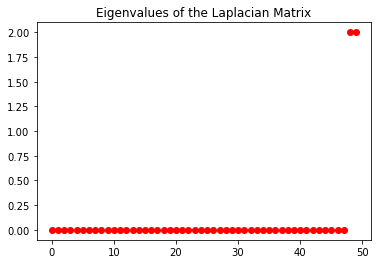

In [23]:
# plot the sorted eigenvalues
plt.plot(np.sort(e),'ro')
plt.title('Eigenvalues of the Laplacian Matrix')

Calculate the number of connected components:

In [24]:
# connected components = dimension of nullspace of L = dim of L - rank of L
len(L) - np.linalg.matrix_rank(L)

48

So there are 22 connected components: we can verify this by counting them on the network plot (note the isolated nodes are also considered to be a connected component).

#### Clustering:

We defined the network by setting a threshold on the distance. In general, we can set the weight of the edge between two cities to be equal to the distance and obtain a weighted graph. Similarly, we can build its Laplacian and use its properties to extract clusters in the data.

Tips for large networks:
* use sparse matrices
* avoid direct computations on the matrices by using efficient algorithms (such as Breadth-First-Search)